In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
data = pd.read_csv("5.csv")

# Separate data into different dataframes based on data types
spo2_data = data[data['data_type'] == 'spo2'].copy()
heart_rate_data = data[data['data_type'] == 'hr'].copy()
steps_data = data[data['data_type'] == 'steps'].copy()
hrv_data = data[data['data_type'] == 'hrv'].copy()
br_data = data[data['data_type'] == 'br'].copy()
sleep_data = data[data['data_type'] == 'sleep'].copy()

# Convert timestamps to datetime format for each dataframe
spo2_data['time'] = pd.to_datetime(spo2_data['time'])
heart_rate_data['time'] = pd.to_datetime(heart_rate_data['time'])
steps_data['time'] = pd.to_datetime(steps_data['time'])
hrv_data['time'] = pd.to_datetime(hrv_data['time'])
br_data['time'] = pd.to_datetime(br_data['time'])
sleep_data['time'] = pd.to_datetime(sleep_data['time'])

# Sort dataframes based on time and their respective formats
spo2_data.sort_values(by='time', inplace=True)
heart_rate_data.sort_values(by='time', inplace=True)
steps_data.sort_values(by='time', inplace=True)
hrv_data.sort_values(by='time', inplace=True)
br_data.sort_values(by='time', inplace=True)
sleep_data.sort_values(by='time', inplace=True)

In [3]:
# Calculate the number of records in each dataframe
num_records_spo2 = spo2_data.shape[0]
num_records_heart_rate = heart_rate_data.shape[0]
num_records_steps = steps_data.shape[0]
num_records_hrv = hrv_data.shape[0]
num_records_br = br_data.shape[0]
num_records_sleep = sleep_data.shape[0]

# Calculate the total number of records
total_records = (
    num_records_spo2 + num_records_heart_rate + num_records_steps +
    num_records_hrv + num_records_br + num_records_sleep
)

# Display the number of records in each dataframe and the total number of records
print("Number of records in Spo2 Data:", num_records_spo2)
print("Number of records in Heart Rate Data:", num_records_heart_rate)
print("Number of records in Steps Data:", num_records_steps)
print("Number of records in HRV Data:", num_records_hrv)
print("Number of records in BR Data:", num_records_br)
print("Number of records in Sleep Data:", num_records_sleep)
print("Total number of records:", total_records)

Number of records in Spo2 Data: 211
Number of records in Heart Rate Data: 7235
Number of records in Steps Data: 1940
Number of records in HRV Data: 211
Number of records in BR Data: 3
Number of records in Sleep Data: 5
Total number of records: 9605


In [4]:
# Assuming your dataframes have been loaded and sorted as per your initial code

def split_data_based_on_days(data, train_size=0.75, test_size=0.25):
    assert train_size + test_size == 1  # Ensure the ratios sum up to 1
    
    unique_days = data['time'].dt.date.unique()
    num_days = len(unique_days)
    num_train = int(num_days * train_size)
    
    train_days = unique_days[:num_train]
    test_days = unique_days[num_train:]
    
    train_data = data[data['time'].dt.date.isin(train_days)]
    test_data = data[data['time'].dt.date.isin(test_days)]
    
    return train_data, test_data

In [5]:
# Apply the function to each dataframe
spo2_train, spo2_test = split_data_based_on_days(spo2_data)
heart_rate_train, heart_rate_test = split_data_based_on_days(heart_rate_data)
steps_train, steps_test = split_data_based_on_days(steps_data)
hrv_train, hrv_test = split_data_based_on_days(hrv_data)
br_train, br_test = split_data_based_on_days(br_data)
sleep_train, sleep_test = split_data_based_on_days(sleep_data)

In [6]:
def list_unique_dates(data):
    """
    Lists all unique dates present in the 'time' column of the input DataFrame.

    Parameters:
    - data: DataFrame with a 'time' column in datetime format.

    Returns:
    - A sorted list of unique dates (as `datetime.date` objects) found in the data.
    """
    unique_dates = data['time'].dt.date.unique()
    unique_dates_sorted = sorted(unique_dates)  # Sorting the dates
    return unique_dates_sorted

In [7]:
heart_rate_unique_dates = list_unique_dates(heart_rate_data)

In [8]:
print("Heart Rate Unique Dates:", heart_rate_unique_dates)

Heart Rate Unique Dates: [datetime.date(2023, 11, 14), datetime.date(2023, 11, 15), datetime.date(2023, 11, 16), datetime.date(2023, 11, 17), datetime.date(2023, 11, 18), datetime.date(2023, 11, 19), datetime.date(2023, 11, 20), datetime.date(2023, 11, 21), datetime.date(2023, 11, 22), datetime.date(2023, 11, 23), datetime.date(2023, 11, 24), datetime.date(2023, 11, 25), datetime.date(2023, 11, 26), datetime.date(2023, 11, 27), datetime.date(2023, 11, 28), datetime.date(2023, 11, 29), datetime.date(2023, 11, 30), datetime.date(2023, 12, 1), datetime.date(2023, 12, 2), datetime.date(2023, 12, 3), datetime.date(2023, 12, 4), datetime.date(2023, 12, 5), datetime.date(2023, 12, 6), datetime.date(2023, 12, 7), datetime.date(2023, 12, 9), datetime.date(2023, 12, 10), datetime.date(2023, 12, 12), datetime.date(2023, 12, 13), datetime.date(2023, 12, 14)]


In [9]:
spo2_unique_dates = list_unique_dates(spo2_data)

In [10]:
print("SPO2 Unique Dates:", spo2_unique_dates)

SPO2 Unique Dates: [datetime.date(2023, 11, 27), datetime.date(2023, 11, 28)]


In [11]:
steps_unique_dates = list_unique_dates(steps_data)

In [12]:
print("Steps Unique Dates:", steps_unique_dates)

Steps Unique Dates: [datetime.date(2023, 11, 14), datetime.date(2023, 11, 15), datetime.date(2023, 11, 16), datetime.date(2023, 11, 17), datetime.date(2023, 11, 18), datetime.date(2023, 11, 19), datetime.date(2023, 11, 20), datetime.date(2023, 11, 21), datetime.date(2023, 11, 22), datetime.date(2023, 11, 23), datetime.date(2023, 11, 24), datetime.date(2023, 11, 25), datetime.date(2023, 11, 26), datetime.date(2023, 11, 27), datetime.date(2023, 11, 28), datetime.date(2023, 11, 29), datetime.date(2023, 11, 30), datetime.date(2023, 12, 1), datetime.date(2023, 12, 2), datetime.date(2023, 12, 3), datetime.date(2023, 12, 4), datetime.date(2023, 12, 5), datetime.date(2023, 12, 6), datetime.date(2023, 12, 7), datetime.date(2023, 12, 8), datetime.date(2023, 12, 9), datetime.date(2023, 12, 10), datetime.date(2023, 12, 11), datetime.date(2023, 12, 12), datetime.date(2023, 12, 13), datetime.date(2023, 12, 14)]


In [13]:
heart_rate_trv=heart_rate_train['value']
heart_rate_tev=heart_rate_test['value']

steps_trv=steps_train['value']
steps_tev=steps_test['value']

In [14]:
print("Heart Rate Train Data:")
print(len(heart_rate_trv))
heart_rate_trv.head()

Heart Rate Train Data:
6702


1    78
3    83
5    83
6    85
7    88
Name: value, dtype: object

In [15]:
print("Steps Train Data:")
print(len(steps_trv))
steps_trv.head()

Steps Train Data:
1713


0     7
2     8
4     7
22    9
24    6
Name: value, dtype: object

In [16]:
# Convert series to numpy array for StandardScaler
heart_rate_tr_values = heart_rate_trv.values.reshape(-1, 1)
heart_rate_te_values = heart_rate_tev.values.reshape(-1, 1)

steps_tr_values = steps_trv.values.reshape(-1, 1)
steps_te_values = steps_tev.values.reshape(-1, 1)


# Initialize the StandardScaler
heart_rate_scaler = StandardScaler()
steps_scaler = StandardScaler()

# Fit and transform the data to standardize it
st_heart_rate_trv = heart_rate_scaler.fit_transform(heart_rate_tr_values)
st_heart_rate_tev = heart_rate_scaler.fit_transform(heart_rate_te_values)

st_steps_trv = steps_scaler.fit_transform(steps_tr_values)
st_steps_tev = steps_scaler.fit_transform(steps_te_values)

In [17]:
print("train: ", len(st_steps_trv))
print("test: ", len(st_steps_tev))

train:  1713
test:  227


In [18]:
def create_windows(data, window_size, step_size):
    segments = []
    for start_pos in range(0, len(data) - window_size + 1, step_size):
        segment = data[start_pos:start_pos + window_size]
        segments.append(segment)
    return np.array(segments)

In [19]:
# Example: 60-minute windows with 30-minute overlap for high-resolution signals
window_size_hr_steps = 30  # 60 minutes
step_size_hr_steps = 15  # 30 minutes overlap

# Apply windowing
steps_trv_windows = create_windows(st_steps_trv, window_size_hr_steps, step_size_hr_steps)
steps_tev_windows = create_windows(st_steps_tev, window_size_hr_steps, step_size_hr_steps)

heart_rate_trv_windows = create_windows(st_heart_rate_trv, window_size_hr_steps, step_size_hr_steps)
heart_rate_tev_windows = create_windows(st_heart_rate_tev, window_size_hr_steps, step_size_hr_steps)

In [20]:
print("train window: ", len(steps_trv_windows))
print("test window: ", len(steps_tev_windows))

train window:  113
test window:  14


In [21]:
def jitter(data, noise_level=0.05):
    """Add random noise to the data."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def scaling(data, scale_factor_range=(0.9, 1.1)):
    """Randomly scale the data."""
    scale_factor = np.random.uniform(scale_factor_range[0], scale_factor_range[1])
    return data * scale_factor

def time_warp(data, sigma=0.2, points=3):
    from scipy.interpolate import CubicSpline
    orig_steps = np.linspace(0, 1, data.shape[1])

    # The corrected line: Generate perturbed versions of orig_steps for each sample in the batch
    random_steps = np.sort(np.random.normal(loc=1, scale=sigma, size=(data.shape[0], orig_steps.shape[0]))) * orig_steps

    warped_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        # Generate a new set of random steps for each sample
        individual_random_steps = np.sort(np.random.normal(loc=orig_steps, scale=sigma, size=orig_steps.shape))
        individual_random_steps[0], individual_random_steps[-1] = 0, 1  # Ensure start and end points remain the same
        warped_data[i] = CubicSpline(orig_steps, data[i])(individual_random_steps)
    return warped_data

def random_crop(data, crop_size):
    """Randomly crop segments from the data."""
    start = np.random.randint(0, data.shape[1] - crop_size + 1)
    return data[:, start:start+crop_size]

def apply_augmentations(data):
    """Apply a sequence of augmentations randomly to each sample."""
    augmented_data = np.zeros_like(data)
    for i, sample in enumerate(data):
        augmented_sample = sample.copy()
        if np.random.rand() < 0.5:
            augmented_sample = jitter(augmented_sample, noise_level=0.05)
        if np.random.rand() < 0.5:
            augmented_sample = scaling(augmented_sample, scale_factor_range=(0.9, 1.1))
        if np.random.rand() < 0.5:
            augmented_sample = time_warp(augmented_sample[np.newaxis, :], sigma=0.2, points=3).squeeze(0)
        augmented_data[i] = augmented_sample
    return augmented_data

In [22]:
# Augment the training data
augmented_steps_trv = apply_augmentations(steps_trv_windows)
augmented_hr_trv = apply_augmentations(heart_rate_trv_windows)

In [23]:
def create_encoder(window_size, num_features):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, num_features)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu')
    ])
    return model

In [24]:
def create_projection_head():
    model = Sequential([
        Dense(64, activation='relu'),
        Dense(32)  # Output vector size for contrastive loss
    ])
    return model

In [25]:
def contrastive_loss(z_i, z_j, temperature=0.1):
    # Calculate the cosine similarity
    z = tf.concat([z_i, z_j], axis=0)
    z_norm = tf.math.l2_normalize(z, axis=1)
    similarities = tf.matmul(z_norm, z_norm, transpose_b=True)
    
    # Scale with temperature
    similarities /= temperature
    
    # Create labels
    batch_size = tf.shape(z_i)[0]
    labels = tf.range(batch_size)
    labels = tf.concat([labels, labels], axis=0)
    
    # Cross-entropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, similarities, from_logits=True)
    return tf.reduce_mean(loss)

In [26]:
def train_step(data, augmented_data, encoder, projection_head, optimizer):
    with tf.GradientTape() as tape:
        z_i = encoder(data, training=True)
        z_j = encoder(augmented_data, training=True)
        z_i_proj = projection_head(z_i, training=True)
        z_j_proj = projection_head(z_j, training=True)
        
        loss = contrastive_loss(z_i_proj, z_j_proj)
        
    gradients = tape.gradient(loss, encoder.trainable_variables + projection_head.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + projection_head.trainable_variables))
    return loss

In [27]:
def train_model(train_dataset, test_dataset, encoder, projection_head, optimizer, epochs=100):
    training_losses = []
    test_losses = []

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()

        # Training loop
        for data_batch, augmented_batch in train_dataset:
            loss = train_step(data_batch, augmented_batch, encoder, projection_head, optimizer)
            epoch_loss_avg.update_state(loss)
        training_losses.append(epoch_loss_avg.result().numpy())

        # Test loss calculation
        test_loss_avg = tf.keras.metrics.Mean()
        for test_data_batch in test_dataset:
            # Ensure the test data is provided in the correct shape to the model
            # This assumes your test_dataset yields single tensors (without augmented pairs)
            if isinstance(test_data_batch, tuple):
                # If the dataset yields a tuple (data, label) or (data, augmented_data), extract only the data part
                test_data_batch = test_data_batch[0]
                
            test_z = encoder(test_data_batch, training=False)
            test_z_proj = projection_head(test_z, training=False)
            # Here, we simulate the contrastive loss with identical inputs since there's no augmented pair in test data
            test_loss = contrastive_loss(test_z_proj, test_z_proj)
            test_loss_avg.update_state(test_loss)
        test_losses.append(test_loss_avg.result().numpy())

        print(f"Epoch {epoch+1}, Training Loss: {training_losses[-1]}, Test Loss: {test_losses[-1]}")

    # Plotting training and test losses
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [28]:
steps_train_dataset = tf.data.Dataset.from_tensor_slices((steps_trv_windows, augmented_steps_trv)).batch(32).shuffle(1000)
steps_test_dataset = tf.data.Dataset.from_tensor_slices((steps_tev_windows, steps_tev_windows)).batch(32)

heart_rate_train_dataset = tf.data.Dataset.from_tensor_slices((heart_rate_trv_windows, augmented_hr_trv)).batch(32).shuffle(1000)
heart_rate_test_dataset = tf.data.Dataset.from_tensor_slices((heart_rate_tev_windows, heart_rate_tev_windows)).batch(32)  # Same as above

In [29]:
print("Training dataset size:", len(list(steps_train_dataset)))
print("Test dataset size:", len(list(steps_test_dataset)))

Training dataset size: 4
Test dataset size: 1


In [30]:
window_size = 30  # Example window size, adjust as needed
num_features = 1  # Adjust based on the number of features in your data

# Initialize the components
encoder = create_encoder(window_size, num_features)
projection_head = create_projection_head()

# Define the learning rate schedule and optimizer
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

Epoch 1, Training Loss: 3.11596941947937, Test Loss: 1.7455226182937622
Epoch 2, Training Loss: 2.953911781311035, Test Loss: 1.5783153772354126
Epoch 3, Training Loss: 2.607028007507324, Test Loss: 1.3425663709640503
Epoch 4, Training Loss: 2.4080004692077637, Test Loss: 1.2336921691894531
Epoch 5, Training Loss: 2.2392845153808594, Test Loss: 1.1225295066833496
Epoch 6, Training Loss: 2.1638882160186768, Test Loss: 1.1548995971679688
Epoch 7, Training Loss: 2.0166029930114746, Test Loss: 1.00615394115448
Epoch 8, Training Loss: 1.9410946369171143, Test Loss: 1.0486340522766113
Epoch 9, Training Loss: 1.855950117111206, Test Loss: 0.9785200953483582
Epoch 10, Training Loss: 1.7711167335510254, Test Loss: 1.0150887966156006
Epoch 11, Training Loss: 1.7369580268859863, Test Loss: 0.9467438459396362
Epoch 12, Training Loss: 1.633586049079895, Test Loss: 0.901904284954071
Epoch 13, Training Loss: 1.550502061843872, Test Loss: 0.9462112188339233
Epoch 14, Training Loss: 1.4831573963165283,

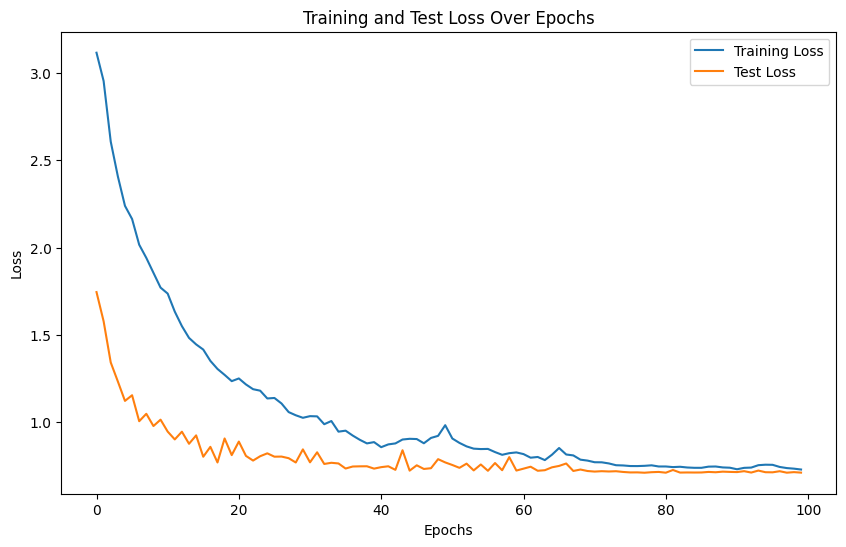

In [31]:
train_model(steps_train_dataset, steps_test_dataset, encoder, projection_head, optimizer)

In [32]:
encoder.save('steps_encoder')

INFO:tensorflow:Assets written to: steps_encoder\assets


INFO:tensorflow:Assets written to: steps_encoder\assets
